Explore some comparisons between manually-delineated end-of-summer snow lines and the results from our automated delineation

In [1]:
import rasterio as rio
import numpy as np
import os
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import geopandas as gpd
import gc
import shapely
import xarray as xr
from rasterio.mask import mask
import importlib

import sys
sys.path.append('../')
import snowFun

In [2]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_validationlines = os.path.join(folder_AGVA, 'Validation', 'Snowline Traces')
folder_mask = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Masks')

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi)

# choose whether to use the 'temporary' products from validaiton subfolder or the 'master' copy
validation_folder_specific = 1

if validation_folder_specific: 
    annual_aa_folder = os.path.join(folder_AGVA, 'Derived Products', 'S2', 'validation', 'Annual AAs')
    annual_ela_folder = os.path.join(folder_AGVA, 'Derived Products', 'S2', 'validation', 'Annual AAs', 'csv')
else:
    annual_aa_folder = os.path.join(folder_AGVA, 'Derived Products', 'S2', 'Annual AAs')
    annual_ela_folder = os.path.join(folder_AGVA, 'Derived Products', 'S2', 'Annual AAs', 'csv')

In [3]:
# open list of validation glaciers
all_validation_df = pd.read_csv(os.path.join(folder_AGVA, 'Validation', 'Validation Glaciers.csv'))
rgis_to_analyze = all_validation_df['RGIId'].values

# get list of glacier area for each rgi
areas = [rgi_gdf[rgi_gdf['RGIId']==i]['Area'].values for i in rgis_to_analyze]

# make df
rgis_to_analyze_df = pd.DataFrame({"RGIId":rgis_to_analyze, 'Area':areas})

# sort however you want
rgis_to_analyze_df = rgis_to_analyze_df.sort_values('Area')

# grab rgi names
rgis_to_analyze = rgis_to_analyze_df['RGIId'].values

print(len(rgis_to_analyze_df))

45


### Lets plots the manually-mapped snowlines for each year on top of the automated end-of-summer snow cover product from each year

37 of 45 - RGI60-01.15731 40.009


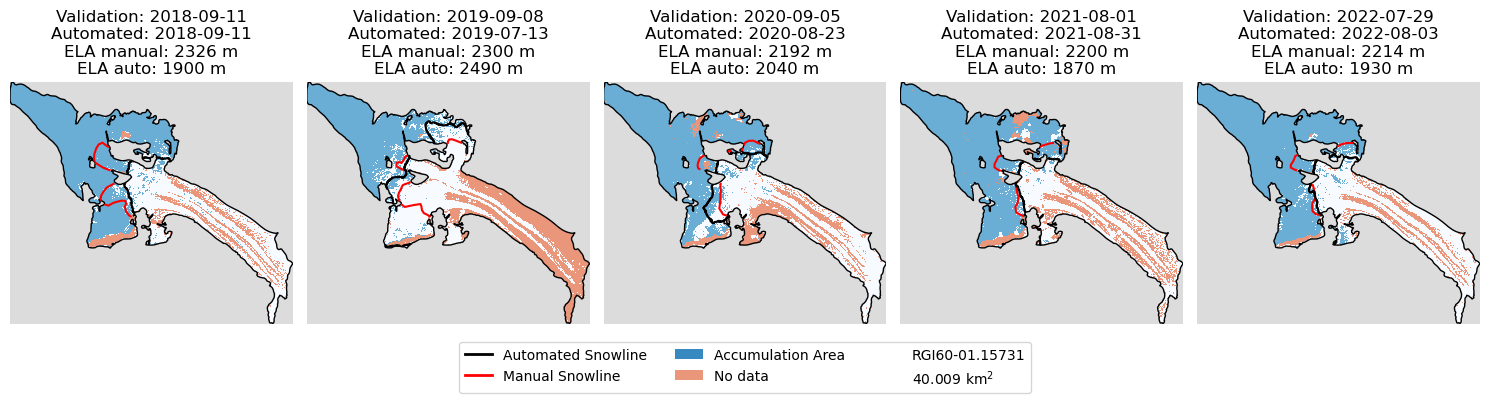

In [4]:
for i in range(len(rgis_to_analyze)):
#     if i<44: continue

    # get rgiid
    rgi_i = rgis_to_analyze[i]
    if rgi_i!='RGI60-01.15731': continue
    # grab the rgi outline that these lines correspond to
    rgi_i_gdf = rgi_gdf[rgi_gdf['RGIId']==rgi_i].to_crs("EPSG:3338")
    ga = rgi_i_gdf['Area'].values[0]
    
    print(f"{i+1} of {len(rgis_to_analyze)} - {rgi_i} {ga}")

    # set file name/path
    name = f'{rgi_i[:5]}_{rgi_i[6:8]}_{rgi_i[9:]}.geojson'
    line_path = os.path.join(folder_validationlines, name)

    # decide which columns you want to drop
    bad_cols = ['id', 'SLCFlag', 'cloudShadowFlag', 'notes', 'otherImageFlag', 'partialPickFlag']
    snowlines_gdf = gpd.read_file(line_path).drop(bad_cols, axis=1).to_crs("EPSG:3338")

    # add year as column
    snowlines_gdf['Year'] = [int(i[:4]) for i in snowlines_gdf['Date']]
    snowlines_gdf.head(10)

    # in some instances there will be multiple entries for a single date
    # (when the user went back to edit a previous image's snowline)
    # in this case, we only want to keep the entry that has the full record (so the one with the latest index)
    snowlines_gdf = snowlines_gdf[~snowlines_gdf.duplicated(subset='Date', keep='last')]

    # clip to rgi outline (buffer inwards 10m to ensure we don't hit the edges)
    snowlines_gdf = snowlines_gdf.clip(rgi_i_gdf.buffer(-10))

    # open files
    annual_aa_path = os.path.join(annual_aa_folder, f"S2_{rgi_i}_2018_2022_annual_AAs.nc")
    annual_aa_xr = xr.open_dataset(annual_aa_path).accumulation_area
    annual_ela_path = os.path.join(annual_ela_folder, f"S2_{rgi_i}_2018_2022_annual_AAs.csv")
    annual_ela_df = pd.read_csv(annual_ela_path)

    # open glacier mask
    glacier_mask = xr.open_dataset(os.path.join(folder_mask, f"S2_{rgi_i}_mask.nc"), chunks='auto').glacier
    if ga>500:
        glacier_mask = glacier_mask.coarsen({"x":3, "y":3}, boundary="trim").median(skipna=True).astype('uint8') 

    elas_manual = []
    elas_auto = []

    ### make a figure with 5 subplots
    fig, axs = plt.subplots(1,5, figsize=(15,7))
    for i in range(5):
        y=i+2018
        ax=axs[i]
    #     if i>0: continue

        # open the time-varying dem for this year
        xr_dem = snowFun.get_year_DEM(rgi_i_gdf.geometry, y, smoothed=0)        
        if ga>500:
            xr_dem = xr_dem.sel({"x":glacier_mask.x, "y":glacier_mask.y})
        xr_dem = xr.where(xr_dem<=0, np.nan, xr_dem)[0]
         
        # grab the automated aa for this year
        aa_y = annual_aa_xr.sel(time=slice(f"{y}-02-01", f"{y}-12-01"))

        # grab the manual validation product for this year
        snowline_y = snowlines_gdf[snowlines_gdf['Year']==y]

        # get manual snowline info if it's there
        if len(snowline_y)>0:
            # sample dem at 20m increments along each snowline
            all_zs = snowFun.sample_dem_along_line(snowline_y, xr_dem, increment=20)

            # get 25,50,75th percentile
            ela_manual_y = [int(i) for i in np.nanpercentile(all_zs, [25,50,75])]
            
            # get the date
            t_val = snowline_y['Date'].values[0]
        
        else:
            ela_manual_y = [0,0,0]
            t_val = f"{y}-01-01"

        # get auto snowline info if it's there
        if len(aa_y.time)>0:
            # get the dates of each
            t_auto = str(aa_y.time.values[0])[:10]

            # get the derived ela
            ela_y = int(annual_ela_df[annual_ela_df['date']==t_auto]['ela'].values[0])

            # format aa_y so that off-glacier is a special color
            aa_y = aa_y.where(glacier_mask, -1)
        
        else:
            ela_y = 0

        # format colormap so nans get a special color
        cmap = matplotlib.colormaps.get_cmap('Blues')  # viridis is the default colormap for imshow
        cmap.set_bad(color='darksalmon')
        cmap.set_under(color='gainsboro')

        # add to the figure
        if len(aa_y.time)>0:
            aa_y[0].plot(ax=ax, cmap=cmap, vmin=1, vmax=3, add_colorbar=False)
            
        rgi_i_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
        
        if len(snowline_y)>0:
            snowline_y.plot(ax=ax, color='Red')
        
        if len(aa_y.time)>0:
            xr.plot.contour(xr_dem, ax=ax, levels=[ela_y], colors='black')

        # add elas to list
        elas_manual.append(ela_manual_y)
        elas_auto.append(ela_y)

        # edit titles, axes, etc...
        ax.set_title(f'Validation: {t_val}\nAutomated: {t_auto}\nELA manual: {ela_manual_y[1]} m\nELA auto: {ela_y} m')

    for ax in axs:
        ax.axis('off')

    plt.tight_layout(w_pad=1)

    # add legend
    labels = ['Automated Snowline', 'Manual Snowline', 'Accumulation Area', 'No data', rgi_i, f"{ga} km$^2$"]
    patches = [Line2D([0], [0], color='black', lw=2),
               Line2D([0], [0], color='red', lw=2),
               Patch(facecolor=cmap(0.66)),
               Patch(facecolor='darksalmon'),
               Patch(facecolor='white'),
               Patch(facecolor='white')]

    axs[2].legend(patches, labels, loc='lower center', ncol=3, borderaxespad=-5)


    # save figure
#     out_path = os.path.join(folder_AGVA, 'Validation', 'Figures', 'maps', f'{rgi_i}.png')
#     plt.savefig(out_path, dpi=300)

#     plt.close()
#     annual_aa_xr=0
#     annual_ela_df=0

In [5]:
annual_ela_df

,date,ela,observed_after_smoothing,aar,off_glacier
0,2018-09-11,1900.0,0.8803,0.5944,False
1,2019-07-13,2490.0,0.7175,0.5039,False
2,2020-08-23,2040.0,0.8446,0.5708,False
3,2021-08-31,1870.0,0.8137,0.6208,False
4,2022-08-03,1930.0,0.9014,0.5967,False


In [ ]:
### make another figure comparing manual and automated ela
error_bars = [[i[0] for i in elas_manual], [i[2] for i in elas_manual]]
xs = [i[1] for i in elas_manual]
ys = elas_auto

# initiate figure
fig,axs = plt.subplots(figsize=(5,5),)

# plot 1-1 line
plt.plot([min(min(xs),min(ys)),max(max(xs),max(ys))],[min(min(xs),min(ys)),max(max(xs),max(ys))],
        c='black', linestyle='dashed')

# plot error bars
axs.hlines(ys, xmin=error_bars[0], xmax=error_bars[1], color='grey', linewidth=1 )

# plot points
axs.scatter(xs, ys, zorder=5)

# edits
axs.set_xlabel('Manual ELA')
axs.set_ylabel('Automated ELA')
plt.tight_layout()
axs.set_aspect('equal')

In [ ]:
# xr_dem = snowFun.get_year_DEM(rgi_i_gdf.geometry, 2019)
# xr_dem = xr.where(xr_dem<=0, np.nan, xr_dem)[0]
# xr_dem.plot()

In [ ]:
# # make figure
# fig, axs = plt.subplots()
# axs.set_facecolor('gainsboro')
# rgi_i_gdf.plot(ax=axs, color='white')
# rgi_i_gdf.boundary.plot(ax=axs, edgecolor='black', linewidth=1)
# snowlines_gdf_clip.plot(ax=axs, column='Year', cmap="RdPu", vmin=2017, vmax=2022, legend=True)
# plt.tight_layout()